In [1]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# CONSTANTS
MODEL = "ViT-B-16-Fine-Tuned"
DATASET = "ISIC_2018"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [273]:
# 1. Load Model and Processor
print("[INFO] Loading model...")

if MODEL == "ViT-B-32":
    model, preprocess = clip.load("ViT-B/32", device=device)
elif MODEL == "ViT-B-16":
    model, preprocess = clip.load("ViT-B/16", device=device)
elif MODEL == "RN50":
    model, preprocess = clip.load("RN50", device=device)
elif MODEL == "RN101":
    model, preprocess = clip.load("RN101", device=device)
elif MODEL == "ViT-L-14":
    model, preprocess = clip.load("ViT-L/14", device=device)
elif MODEL == "RN50x16":
    model, preprocess = clip.load("RN50x16", device=device)
elif MODEL == "ViT-B-32-FT":
    model, preprocess = clip.load("ViT-B/32", device=device)
    checkpoint = torch.load("ft_models/CLIP_D7PT_ViT-B-32_best.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
elif MODEL == "ViT-B-16-FT":
    model, preprocess = clip.load("ViT-B/16", device=device)
    checkpoint = torch.load("ft_models/model_D7PT_ViT16.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

print("[INFO] Model loaded successfully!")

[INFO] Loading model...
[INFO] Model loaded successfully!


In [4]:
CLASS_LABELS_PROMPTS = {
    "BKL": ["This is dermatoscopy of pigmented benign keratosis", 'This is dermoscopy of pigmented benign keratosis'],
    "NV": ["This is dermatoscopy of nevus", 'This is dermoscopy of nevus'],
    "DF": ['This is dermatoscopy of dermatofibroma', 'This is dermoscopy of dermatofibroma'],
    "MEL": ['This is dermatoscopy of melanoma', 'This is dermoscopy of melanoma'],
    "VASC": ['This is dermatoscopy of vascular lesion', 'This is dermoscopy of vascular lesion'],
    "BCC": ['This is dermatoscopy of basal cell carcinoma', 'This is dermoscopy of basal cell carcinoma'],
    "AKIEC": ['This is dermatoscopy of actinic keratosis', 'This is dermoscopy of actinic keratosis']
}

In [275]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy", "This is dermoscopy"]

In [276]:
# Extract text features for each concept and save it to a numpy array
for disease_label in CLASS_LABELS_PROMPTS.keys():
    text = clip.tokenize(CLASS_LABELS_PROMPTS[disease_label]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text)
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/class_label_embeddings_{disease_label}_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [277]:
# Extract text features for each concept and save it to a numpy array
text = clip.tokenize(REFERENCE_CONCEPT_PROMPTS).to(device)

with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

np.save(f"text_embeddings/reference_prompts_embeddings_ISIC_2018_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [5]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [6]:
def get_concept_score(image_features_norm,
                      prompt_target_embedding_norm,
                      prompt_ref_embedding_norm):

    #print(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    sim_cos_concept = image_features_norm.float() @ prompt_target_embedding_norm.T.float()
    sim_cos_ref = image_features_norm.float() @ prompt_ref_embedding_norm.T.float() 
    temp = (1/np.exp(4.5944))

    return (np.exp(sim_cos_concept.numpy() / temp) / (np.exp(sim_cos_concept.numpy() / temp) + np.exp(sim_cos_ref.numpy() / temp))).mean()

In [10]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")

#img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_CLIP_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()
# Segmented Version
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()

#img_embeddings = np.load(f"img_embeddings/image_embeddings_ISIC_2018_{MODEL}_Original_80_samples_per_class_best.npy", allow_pickle=True).item()
#reference_embeddings = torch.from_numpy(np.load(f"text_embeddings/reference_prompts_dermatoscopy_ISIC_2018_{MODEL}_80_samples_per_class_best.npy")).unsqueeze(0)
#reference_embeddings = torch.from_numpy(np.load(f"text_embeddings/reference_prompts_embeddings_ISIC_2018_{MODEL}.npy")).unsqueeze(0)
#reference_embeddings = torch.from_numpy(np.load(f"text_embeddings/reference_prompts_embeddings_ISIC_2018_{MODEL}.npy")).unsqueeze(0)

# Segmented Version
reference_embeddings = torch.from_numpy(np.load(f"text_embeddings/reference_prompts_dermatoscopy_ISIC_2018_{MODEL}_Segmented_Norm.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_{MODEL}_Segmented_Norm.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")
        text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_{MODEL}.npy")).unsqueeze(0)

        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=False)
        
        concept_score = get_concept_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats[0],
                                                prompt_ref_embedding_norm=reference_embeddings[0])

        #similarity_scores.append(similarity[0])
        similarity_scores.append(similarity)
        #similarity_scores.append(concept_score)

    # Calculate prediction given weights of melanoma
    results[im] = similarity_scores

[INFO] DATASET: ISIC_2018
[INFO] MODEL: ViT-B-16-Fine-Tuned


In [11]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "ISIC_2018":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/image_classes_ISIC_2018.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/HAM10000/ISIC_2018_test.csv")
    test_images = test_images_df["images"].tolist()

"""
y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

        print(y_true_val)
        print(y_pred_probs_val)

    break

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
"""

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(np.argmax(results[im]))
        y_pred_probs.append(results[im])
        
target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

n_classes = len(target_names)
for i, c in enumerate(target_names):
    tp = conf_matrix[i, i]
    fn = sum(conf_matrix[i, :]) - tp
    fp = sum(conf_matrix[:, i]) - tp
    tn = sum(sum(conf_matrix)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {c}: Sensitivity = {tpr:.3f}, Specificity = {tnr:.3f}, BACC = {((tpr + tnr) / 2):.3f}")

              precision    recall  f1-score   support

         BKL       0.07      0.22      0.11       217
          NV       0.58      0.35      0.43       908
          DF       0.00      0.00      0.00        44
         MEL       0.22      0.32      0.26       171
        VASC       0.00      0.00      0.00        35
         BCC       0.00      0.00      0.00        93
       AKIEC       0.00      0.00      0.00        43

    accuracy                           0.28      1511
   macro avg       0.12      0.13      0.11      1511
weighted avg       0.38      0.28      0.31      1511

[[ 48  91   1  76   0   1   0]
 [552 316   4  19   6   1  10]
 [  6  25   0  13   0   0   0]
 [ 70  42   0  54   4   0   1]
 [  2  29   0   4   0   0   0]
 [  2  31   0  58   1   0   1]
 [  3  11   0  26   3   0   0]]
Class BKL: Sensitivity = 0.221, Specificity = 0.509, BACC = 0.365
Class NV: Sensitivity = 0.348, Specificity = 0.620, BACC = 0.484
Class DF: Sensitivity = 0.000, Specificity = 0.997, BA

In [12]:
from sklearn.preprocessing import label_binarize

test_labels = label_binarize(y_true,
                        classes=[0, 1, 2, 3, 4, 5, 6])

In [15]:
prob_test_vec = np.array(y_pred_probs)
 
n_classes = 7
fpr = [0] * 7
tpr = [0] * 7
thresholds = [0] * 7
auc_score = [0] * 7

target_names=['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']

for i, c in enumerate(target_names):
    fpr[i], tpr[i], thresholds[i] = roc_curve(test_labels[:, i],
                                              prob_test_vec[:, i])

    if i == 3:
        np.save("fpr_ISIC_2018_standard.npy", fpr[i])
        np.save("tpr_ISIC_2018_standard.npy", tpr[i])

    auc_score[i] = auc(fpr[i], tpr[i])
    print(f"AUC {c}: {auc(fpr[i], tpr[i])}")

print(f"Mean AUC: {np.mean(auc_score)}")

AUC BKL: 0.3220393307644641
AUC NV: 0.47481023662889665
AUC DF: 0.33757823635124246
AUC MEL: 0.6793226848215065
AUC VASC: 0.2709252806813782
AUC BCC: 0.34493531704505814
AUC AKIEC: 0.3489005766427983
Mean AUC: 0.39693023756219203


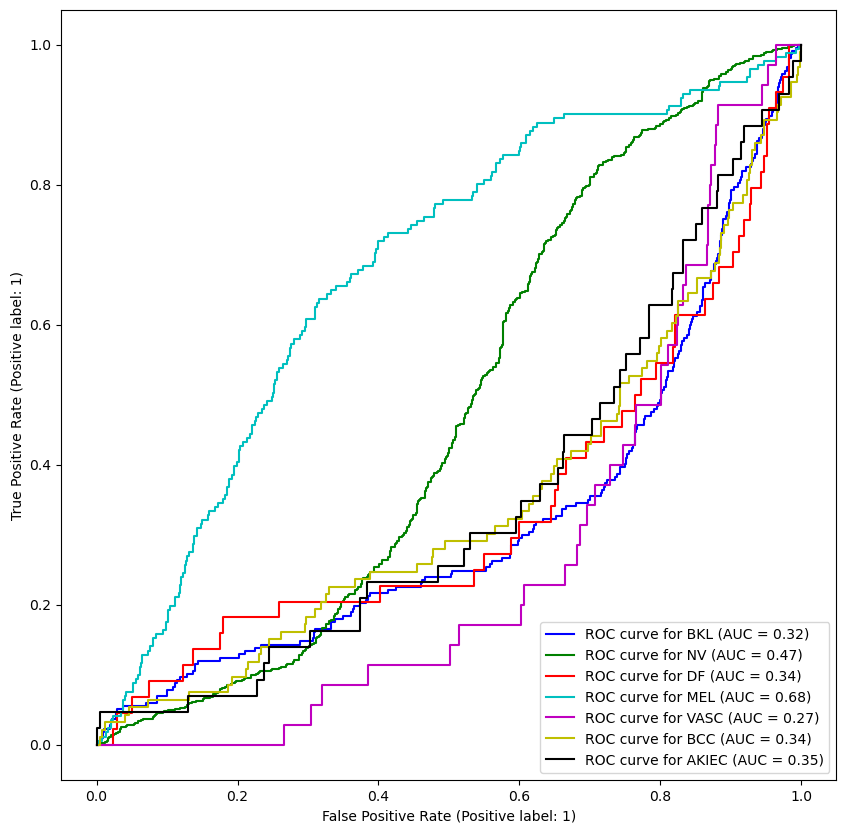

In [14]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from itertools import cycle
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
target_names = ['BKL', 'NV', 'DF', 'MEL', 'VASC', 'BCC', 'AKIEC']
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        test_labels[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

In [324]:
img_emb = np.random.randn(1, 768)
con_emb = np.random.randn(1, 768)
ref_emb = np.random.randn(2, 768)

con_emb /= np.linalg.norm(con_emb)
img_emb /= np.linalg.norm(img_emb)
ref_emb /= np.linalg.norm(ref_emb)

sim_cos_concept = np.dot(img_emb, img_emb.T)
print(sim_cos_concept)
sim_cos_ref = np.dot(img_emb, ref_emb.T)
print(sim_cos_ref)
temp = (1/np.exp(4.5944))

score = (np.exp(sim_cos_concept / temp) / (np.exp(sim_cos_concept / temp) + np.exp(sim_cos_ref / temp))).mean()
print(score)

[[1.]]
[[ 0.01295302 -0.00946458]]
1.0
